# **LOAD DATA**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset_DSA/munich.csv")
display(df.head())

,day,interval,detid,flow,occ,error,city,speed
0,2017-02-14,600,4118014,57.3,0.005,NaN,munich,NaN
1,2017-02-14,900,4118014,10.0,0.000,1.0,munich,NaN
2,2017-02-14,1200,4118014,12.3,0.000,1.0,munich,NaN
3,2017-02-14,1500,4118014,19.8,0.000,1.0,munich,NaN
4,2017-02-14,1800,4118014,24.6,0.000,1.0,munich,NaN


# **Random Forest - Alur Lalu Lintas**
> * Untuk prediksi `flow` berdasarkan `interval`
> * Drop kolom berikut untuk memprediksi
> > * `day`
> > * `detid`
> > * `speed`
> > * `city`
> > * `occ`
>
> Setelah itu akan dilakukan penghapusan missing values pada Kolom `error`, sehingga diperoleh dataset baru yang bersih dan tidak ada kesalahan pengukuran.

In [ ]:
import numpy as np

# Drop the 'speed' column as it contains only NaN values
df_cleaned = df.drop(columns=['day','detid','speed','city','occ'])

# Filter out rows where 'error' is equal to 1. Keep rows where 'error' is not 1 or is NaN.
df_cleaned_2 = df_cleaned[ (df_cleaned['error'] != 1) | (df_cleaned['error'].isna()) ]

# Outlier removal using IQR for 'flow' column
Q1_flow = df_cleaned_2['flow'].quantile(0.25)
Q3_flow = df_cleaned_2['flow'].quantile(0.75)
IQR_flow = Q3_flow - Q1_flow

lower_bound_flow = Q1_flow - 1.5 * IQR_flow
upper_bound_flow = Q3_flow + 1.5 * IQR_flow

df_cleaned_2 = df_cleaned_2[(df_cleaned_2['flow'] >= lower_bound_flow) & (df_cleaned_2['flow'] <= upper_bound_flow)]

display(df_cleaned_2.head())

df_cleaned_last = df_cleaned_2.drop(columns=['error'])

# Display the first few rows of the cleaned DataFrame
print("\nDrop Error and Outliers from 'flow' column")
display(df_cleaned_last.head())

,interval,flow,error
0,600,57.3,NaN
7,2700,0.0,NaN
10,3600,0.0,NaN
12,4200,0.0,NaN
13,4500,0.0,NaN



Drop Error and Outliers from 'flow' column


,interval,flow
0,600,57.3
7,2700,0.0
10,3600,0.0
12,4200,0.0
13,4500,0.0


In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_cleaned_2.drop('flow', axis=1)
y = df_cleaned_2['flow']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (61840, 2)
Shape of X_test: (26504, 2)
Shape of y_train: (61840,)
Shape of y_test: (26504,)


In [ ]:
import lightgbm as lgb # Import LightGBM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Persiapan Data ---
# X = interval, y = flow
X = df_cleaned_last[['interval']]
y_flow = df_cleaned_last['flow']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_flow, test_size=0.3, random_state=42)

# --- Membuat Model LGBM ---
# n_estimators: jumlah pohon
# learning_rate: seberapa cepat model belajar
lgbm_modelFlow = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)

# Latih Model
lgbm_modelFlow.fit(X_train, y_train)

# --- Evaluasi Model ---
y_pred_lgbm = lgbm_modelFlow.predict(X_test)

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("--- LGBM Regressor untuk Alur Lalu Lintas ---")
print(f"Mean Absolute Error (MAE): {mae_lgbm:.2f}")
print(f"Mean Squared Error (MSE): {mse_lgbm:.2f}")
print(f"R-squared (R2): {r2_lgbm:.2f}")
print(f"Akurasi R-squared (R2) model adalah: {r2_lgbm*100:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 61840, number of used features: 1
[LightGBM] [Info] Start training from score 250.487494
--- LGBM Regressor untuk Alur Lalu Lintas ---
Mean Absolute Error (MAE): 106.54
Mean Squared Error (MSE): 21490.29
R-squared (R2): 0.37
Akurasi R-squared (R2) model adalah: 37.42%


# **Random Forest - Okupansi Jalan**
> * Untuk prediksi `occ` berdasarkan `interval`
> * Drop kolom berikut untuk memprediksi
> > * `day`
> > * `detid`
> > * `speed`
> > * `city`
> > * `flow`
>
> Setelah itu akan dilakukan penghapusan missing values pada Kolom `error`, sehingga diperoleh dataset baru yang bersih dan tidak ada kesalahan pengukuran.

In [ ]:
# Drop the 'speed' column as it contains only NaN values
df_cleaned = df.drop(columns=['day','detid','speed','city','flow'])

# Filter out rows where 'error' is equal to 1. Keep rows where 'error' is not 1 or is NaN.
df_cleaned_2 = df_cleaned[ (df_cleaned['error'] != 1) | (df_cleaned['error'].isna()) ]
display(df_cleaned_2.head())

# Outlier removal using IQR for 'occ' column
Q1_occ = df_cleaned_2['occ'].quantile(0.25)
Q3_occ = df_cleaned_2['occ'].quantile(0.75)
IQR_occ = Q3_occ - Q1_occ

lower_bound_occ = Q1_occ - 1.5 * IQR_occ
upper_bound_occ = Q3_occ + 1.5 * IQR_occ

df_cleaned_2 = df_cleaned_2[(df_cleaned_2['occ'] >= lower_bound_occ) & (df_cleaned_2['occ'] <= upper_bound_occ)]

df_cleaned_last = df_cleaned_2.drop(columns=['error'])

# Display the first few rows of the cleaned DataFrame
print("\nDrop Error and Outliers from 'occ' column")
display(df_cleaned_last.head())

,interval,occ,error
0,600,0.005,NaN
7,2700,0.000,NaN
10,3600,0.000,NaN
12,4200,0.000,NaN
13,4500,0.000,NaN



Drop Error and Outliers from 'occ' column


,interval,occ
0,600,0.005
7,2700,0.000
10,3600,0.000
12,4200,0.000
13,4500,0.000


In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_cleaned_2.drop('occ', axis=1)
y = df_cleaned_2['occ']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (60749, 2)
Shape of X_test: (26036, 2)
Shape of y_train: (60749,)
Shape of y_test: (26036,)


In [ ]:
import lightgbm as lgb # Import LightGBM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Persiapan Data ---
# X = interval, y = flow
X = df_cleaned_last[['interval']]
y_flow = df_cleaned_last['occ']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_flow, test_size=0.3, random_state=42)

# --- Membuat Model LGBM ---
# n_estimators: jumlah pohon
# learning_rate: seberapa cepat model belajar
lgbm_modelOcc = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)

# Latih Model
lgbm_modelOcc.fit(X_train, y_train)

# --- Evaluasi Model ---
y_pred_lgbm = lgbm_modelOcc.predict(X_test)

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("--- LGBM Regressor untuk Okupansi Jalan ---")
print(f"Mean Absolute Error (MAE): {mae_lgbm:.2f}")
print(f"Mean Squared Error (MSE): {mse_lgbm:.2f}")
print(f"R-squared (R2): {r2_lgbm:.2f}")
print(f"Akurasi R-squared (R2) model adalah: {r2_lgbm*100:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 60749, number of used features: 1
[LightGBM] [Info] Start training from score 0.072145
--- LGBM Regressor untuk Okupansi Jalan ---
Mean Absolute Error (MAE): 0.04
Mean Squared Error (MSE): 0.00
R-squared (R2): 0.31
Akurasi R-squared (R2) model adalah: 31.15%


# **Klasifikasi Kemacetan**

> Menggunakan teori fuzzifikasi untuk klasifikasi dengan rules tertentu berdasarkan grafik lineplot dari,
> * `interval` vs `flow`
> * `interval` vs `occ`

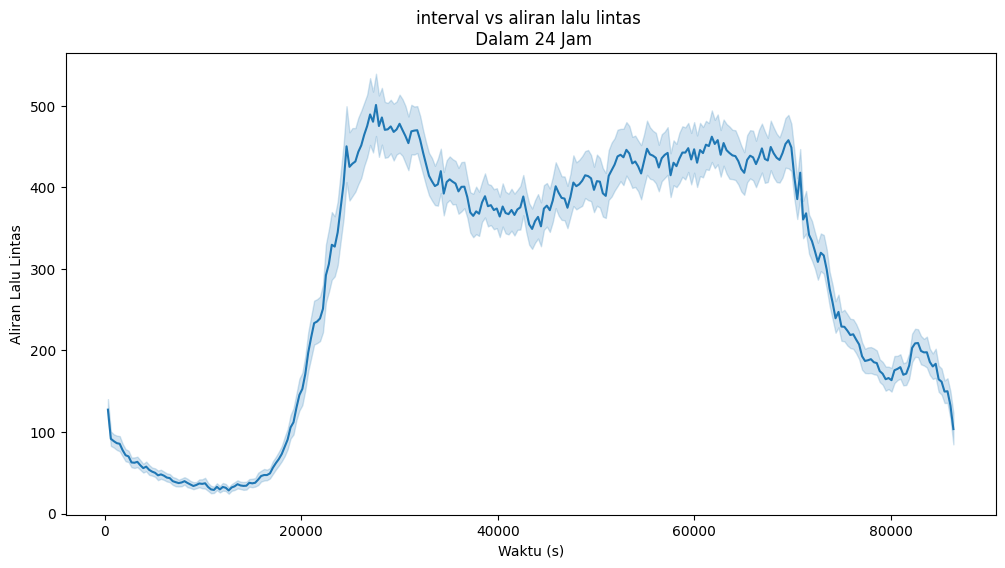

In [ ]:
# Recreate df_cleaned_2 with 'flow' column for this plot, based on initial cleaning for flow prediction
df_for_flow_plot = df.drop(columns=['day','detid','speed','city','occ'])
df_for_flow_plot = df_for_flow_plot[ (df_for_flow_plot['error'] != 1) | (df_for_flow_plot['error'].isna()) ]

plt.figure(figsize=(12, 6))
sns.lineplot(x='interval', y='flow', data=df_for_flow_plot)
plt.xlabel('Waktu (s)')
plt.ylabel('Aliran Lalu Lintas')
plt.title('interval vs aliran lalu lintas \n Dalam 24 Jam')
plt.show()

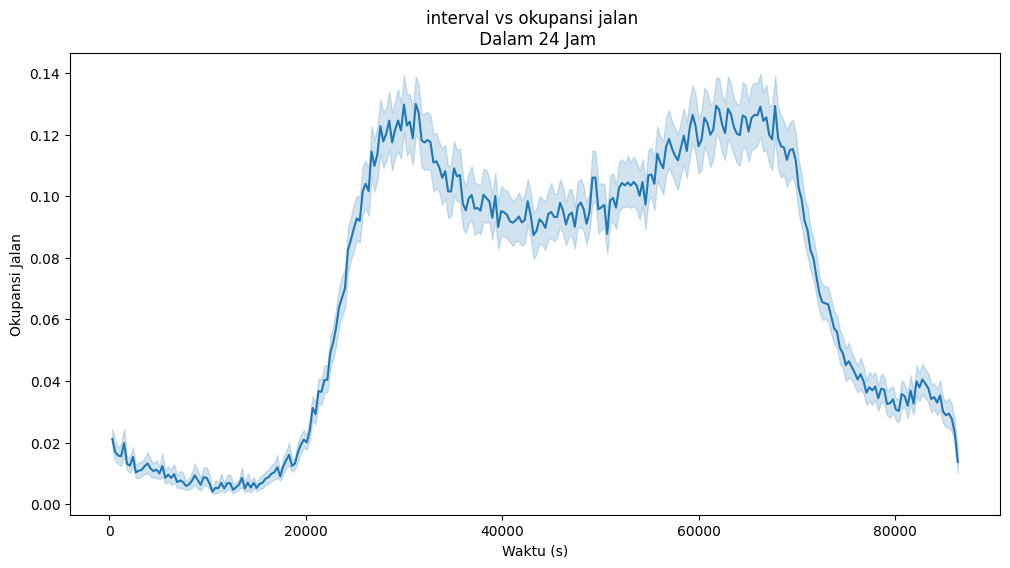

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='interval', y='occ', data=df_cleaned_2)
plt.xlabel('Waktu (s)')
plt.ylabel('Okupansi Jalan')
plt.title('interval vs okupansi jalan \n Dalam 24 Jam')
plt.show()

In [ ]:
!pip install scikit-fuzzy

In [ ]:
import skfuzzy as fuzz
import numpy as np
from skfuzzy import control as ctrl
import skfuzzy as fuzz
from skfuzzy import control as ctrl

def fuzzydefining(predicted_flow, predicted_occ):

  # Define universe for 'flow' (0 to 1000, based on max flow observation from data)
  # Max flow in df_cleaned_2 is around 750, so setting max to 1000 seems reasonable.
  flow = np.arange(0, 1001, 1)

  # Define universe for 'occupancy' (0 to 1, as it's a percentage or ratio)
  occ = np.arange(0, 1.01, 0.01)

  # Define universe for output 'congestion' (0 to 100, representing severity)
  congestion = np.arange(0, 101, 1)

  # Define membership functions for 'flow'
  flow_low = fuzz.trimf(flow, [0, 0, 300])
  flow_medium = fuzz.trimf(flow, [200, 450, 700])
  flow_high = fuzz.trimf(flow, [600, 1000, 1000])

  # Define membership functions for 'occupancy'
  occ_low = fuzz.trimf(occ, [0, 0, 0.3])
  occ_medium = fuzz.trimf(occ, [0.2, 0.5, 0.8])
  occ_high = fuzz.trimf(occ, [0.7, 1, 1])

  # Define membership functions for 'congestion'
  congestion_low = fuzz.trimf(congestion, [0, 0, 40])
  congestion_medium = fuzz.trimf(congestion, [30, 60, 90])
  congestion_high = fuzz.trimf(congestion, [80, 100, 100])

  # print("Fuzzy universes and membership functions for 'flow', 'occupancy', and 'congestion' have been defined.")


  # New Antecedent/Consequent objects hold universe variables and membership functions
  flow_antecedent = ctrl.Antecedent(flow, 'flow')
  occ_antecedent = ctrl.Antecedent(occ, 'occ')
  congestion_consequent = ctrl.Consequent(congestion, 'congestion')

  # Assign membership functions to the Antecedents and Consequents
  flow_antecedent['low'] = flow_low
  flow_antecedent['medium'] = flow_medium
  flow_antecedent['high'] = flow_high

  occ_antecedent['low'] = occ_low
  occ_antecedent['medium'] = occ_medium
  occ_antecedent['high'] = occ_high

  congestion_consequent['Lancar'] = congestion_low
  congestion_consequent['Padat Merayap'] = congestion_medium
  congestion_consequent['Macet'] = congestion_high

  # Define fuzzy rules
  rule1 = ctrl.Rule(flow_antecedent['high'] & occ_antecedent['low'], congestion_consequent['Lancar'])
  rule2 = ctrl.Rule(flow_antecedent['medium'] & occ_antecedent['low'], congestion_consequent['Lancar'])
  rule3 = ctrl.Rule(flow_antecedent['low'] & occ_antecedent['low'], congestion_consequent['Lancar'])

  rule4 = ctrl.Rule(flow_antecedent['high'] & occ_antecedent['medium'], congestion_consequent['Padat Merayap'])
  rule5 = ctrl.Rule(flow_antecedent['medium'] & occ_antecedent['medium'], congestion_consequent['Padat Merayap'])
  rule6 = ctrl.Rule(flow_antecedent['low'] & occ_antecedent['medium'], congestion_consequent['Macet'])

  rule7 = ctrl.Rule(flow_antecedent['high'] & occ_antecedent['high'], congestion_consequent['Padat Merayap'])
  rule8 = ctrl.Rule(flow_antecedent['medium'] & occ_antecedent['high'], congestion_consequent['Padat Merayap'])
  rule9 = ctrl.Rule(flow_antecedent['low'] & occ_antecedent['high'], congestion_consequent['Macet'])

  # print("Fuzzy rules for congestion classification have been defined.")

    # Create a ControlSystem object
  congestion_ctrl = ctrl.ControlSystem([
      rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9
  ])

  # Create a ControlSystemSimulation object
  congestion_simulation = ctrl.ControlSystemSimulation(congestion_ctrl)

  # Pass the input values to the simulation
  # Ensure predicted_flow and predicted_occ are scalars
  congestion_simulation.input['flow'] = predicted_flow[0] if isinstance(predicted_flow, np.ndarray) else predicted_flow
  congestion_simulation.input['occ'] = predicted_occ[0] if isinstance(predicted_occ, np.ndarray) else predicted_occ

  # Compute the result
  congestion_simulation.compute()

  # Get the defuzzified output
  congestion_level = congestion_simulation.output['congestion']

  # Map the numerical congestion level to a categorical label
  if congestion_level <= 30:
      congestion_status = "Lancar"
  elif congestion_level <= 70:
      congestion_status = "Padat Merayap"
  else:
      congestion_status = "Macet"

  print(f" Arus Lalu Lintas : {predicted_flow[0]:.2f}")
  print(f"Persentase Okupansi Jalan   : {predicted_occ[0]:.2f}%")
  print(f"Status Jalanan: {congestion_status}")
  print(f"Dengan Level sebesar : {congestion_level:.2f}")

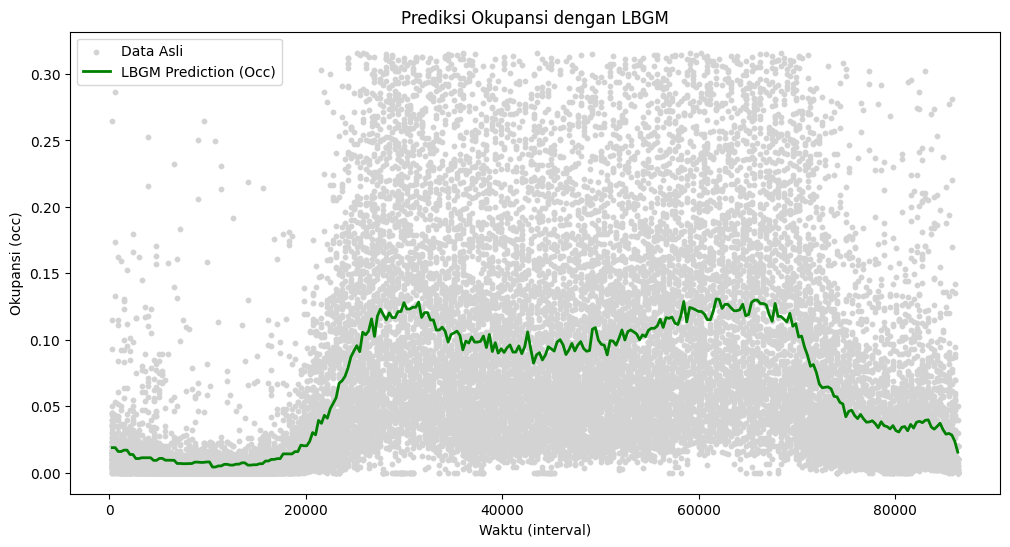

In [ ]:
import matplotlib.pyplot as plt

# Predict on the test set for plotting
y_pred_xgb_occ_test = lgbm_modelOcc.predict(X_test)

plt.figure(figsize=(12, 6))
# Plot data asli (from test set)
plt.scatter(X_test['interval'], y_test, color='lightgray', s=10, label='Data Asli')

# Sort X_test by interval to get a smooth line plot for predictions
sorted_indices = X_test['interval'].argsort()
plt.plot(X_test['interval'].iloc[sorted_indices], y_pred_xgb_occ_test[sorted_indices], color='green', linewidth=2, label='LBGM Prediction (Occ)')

plt.xlabel('Waktu (interval)')
plt.ylabel('Okupansi (occ)')
plt.title('Prediksi Okupansi dengan LBGM')
plt.legend()
plt.show()

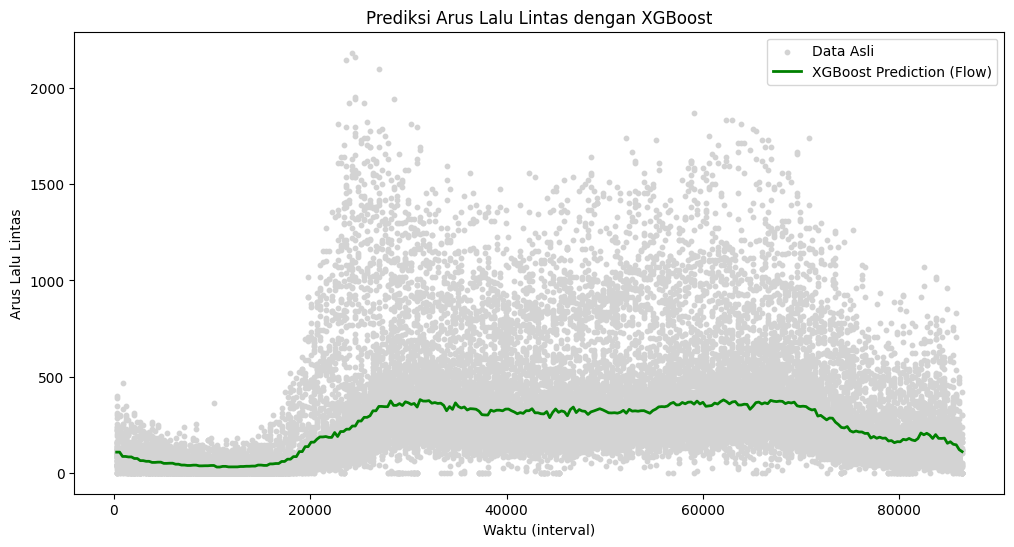

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- Re-prepare data for flow prediction context for plotting ---
# The original df_cleaned_last for flow was prepared in cell HTqdhp9aR8VJ
# and then X and y_flow were defined in zD9oA4_5kkwL.
# We will recreate the split to ensure correct X_test_flow and y_test_flow.

df_cleaned_flow_temp = df.drop(columns=['day','detid','speed','city','occ'])
df_cleaned_flow_temp = df_cleaned_flow_temp[ (df_cleaned_flow_temp['error'] != 1) | (df_cleaned_flow_temp['error'].isna()) ]
df_cleaned_last_flow = df_cleaned_flow_temp.drop(columns=['error'])

X_flow_data = df_cleaned_last_flow[['interval']]
y_flow_data = df_cleaned_last_flow['flow']

# Split Data specifically for flow plotting (using the same random_state as training)
_, X_test_flow, _, y_test_flow = train_test_split(X_flow_data, y_flow_data, test_size=0.3, random_state=42)

# Predict on the test set for plotting using the xgb_modelFlow
y_pred_xgb_flow_test = lgbm_modelFlow.predict(X_test_flow)

plt.figure(figsize=(12, 6))
# Plot data asli (from test set)
plt.scatter(X_test_flow['interval'], y_test_flow, color='lightgray', s=10, label='Data Asli')

# Sort X_test_flow by interval to get a smooth line plot for predictions
sorted_indices_flow = X_test_flow['interval'].argsort()
plt.plot(X_test_flow['interval'].iloc[sorted_indices_flow], y_pred_xgb_flow_test[sorted_indices_flow], color='green', linewidth=2, label='XGBoost Prediction (Flow)')

plt.xlabel('Waktu (interval)')
plt.ylabel('Arus Lalu Lintas')
plt.title('Prediksi Arus Lalu Lintas dengan XGBoost')
plt.legend()
plt.show()

# **Input dari User**

> Input agar user mendapatkan prediksi apakah pada jam tertentu terdapat kemacetan

In [ ]:
import pandas as pd
import numpy as np

# --- Input for modelFlow (predicting 'flow') ---
print("--- Prediksi Input Dari User ---")
interval_input = float(input("Interval dalam detik (0 - 86400): "))

# Create DataFrame for flow prediction, only with the 'interval' feature as used in training
interval_user_input = pd.DataFrame({
    'interval': [interval_input]
})

# Make prediction using modelFlow
predicted_flow = lgbm_modelFlow.predict(interval_user_input)
predicted_occ = lgbm_modelOcc.predict(interval_user_input)
fuzzydefining(predicted_flow, predicted_occ)

--- Prediksi Input Dari User ---
Interval dalam detik (0 - 86400): 25500
 Arus Lalu Lintas : 287.99
Persentase Okupansi Jalan   : 0.09%
Status Jalanan: Lancar
Dengan Level sebesar : 16.73


In [ ]:
import joblib

# Contoh simpan model Flow
# Ganti nama variabel sesuai model Anda yang sudah dilatih
joblib.dump(lgbm_modelFlow, 'model_flow_lgbm.pkl')      # Polynomial

# Contoh simpan model Occupancy
joblib.dump(lgbm_modelOcc, 'model_occ_lgbm.pkl')

print("Semua model berhasil disimpan! Silakan download file .pkl dari folder Colab.")

Semua model berhasil disimpan! Silakan download file .pkl dari folder Colab.
